# Deploy a Trained PyTorch Model

In this notebook, we walk through the process of deploying a trained model to a SageMaker endpoint. If you recently ran [the notebook for training](get_started_mnist_deploy.ipynb) with `%store%` magic, the `model_data` can be restored. Otherwise, we retrieve the 
model artifact from a public S3 bucket.

In [3]:
# setups

import os
import json

import boto3
import sagemaker
from sagemaker.pytorch import PyTorchModel
from sagemaker import get_execution_role, Session

# Get global config
with open("code/config.json", "r") as f:
    CONFIG = json.load(f)

sess = Session()

role = get_execution_role()

%store -r pt_mnist_model_data

try:
    pt_mnist_model_data
except NameError:
    import json

    # copy a pretrained model from a public public to your default bucket
    s3 = boto3.client("s3")
    bucket = CONFIG["public_bucket"]
    key = "datasets/image/MNIST/model/pytorch-training-2020-11-21-22-02-56-203/model.tar.gz"
    s3.download_file(bucket, key, "model.tar.gz")

    # upload to default bucket
    pt_mnist_model_data = sess.upload_data(
        path="model.tar.gz", bucket=sess.default_bucket(), key_prefix="model/pytorch"
    )

no stored variable or alias pt_mnist_model_data


In [4]:
print(pt_mnist_model_data)

s3://sagemaker-us-east-1-233395505052/model/pytorch/model.tar.gz


## PyTorch Model Object

The `PyTorchModel` class allows you to define an environment for making inference using your
model artifact. Like the `PyTorch` class discussed 
[in this notebook for training an PyTorch model](get_started_mnist_train.ipynb), it is a high level API used to set up a docker image for your model hosting service.

Once it is properly configured, it can be used to create a SageMaker
endpoint on an EC2 instance. The SageMaker endpoint is a containerized environment that uses your trained model 
to make inference on incoming data via RESTful API calls. 

Some common parameters used to initiate the `PyTorchModel` class are:
- `entry_point`: A user defined python file to be used by the inference image as handlers of incoming requests
- `source_dir`: The directory of the `entry_point`
- `role`: An IAM role to make AWS service requests
- `model_data`: the S3 location of the compressed model artifact. It can be a path to a local file if the endpoint 
is to be deployed on the SageMaker instance you are using to run this notebook (local mode)
- `framework_version`: version of the PyTorch package to be used
- `py_version`: python version to be used

We elaborate on the `entry_point` below.



In [5]:
model = PyTorchModel(
    entry_point="inference.py",
    source_dir="code",
    role=role,
    model_data=pt_mnist_model_data,
    framework_version="1.5.0",
    py_version="py3",
)

### Entry Point for the Inference Image

Your model artifacts pointed by `model_data` is pulled by the `PyTorchModel` and it is decompressed and saved in
in the docker image it defines. They become regular model checkpoint files that you would produce outside SageMaker. This means in order to use your trained model for serving, 
you need to tell `PyTorchModel` class how to a recover a PyTorch model from the static checkpoint.

Also, the deployed endpoint interacts with RESTful API calls, you need to tell it how to parse an incoming 
request to your model. 

These two instructions needs to be defined as two functions in the python file pointed by `entry_point`.

By convention, we name this entry point file `inference.py` and we put it in the `code` directory.

To tell the inference image how to load the model checkpoint, you need to implement a function called 
`model_fn`. This function takes one positional argument 

- `model_dir`: the directory of the static model checkpoints in the inference image.

The return of `model_fn` is a PyTorch model. In this example, the `model_fn`
looks like:

```python
def model_fn(model_dir): 
    model = Net()   
    with open(os.path.join(model_dir, "model.pth"), "rb") as f:
        model.load_state_dict(torch.load(f))
    model.to(device).eval()
    return model
```

Next, you need to tell the hosting service how to handle the incoming data. This includes:

* How to parse the incoming request
* How to use the trained model to make inference
* How to return the prediction to the caller of the service


You do it by implementing 3 functions:

#### `input_fn` function

The SageMaker PyTorch model server will invoke the `input_fn` function in your inference entry point. This function handles data decoding. The `input_fn` have the following signature:
```python
def input_fn(request_body, request_content_type)
```
The two positional arguments are:
- `request_body`: the payload of the incoming request
- `request_content_type`: the content type of the incoming request

The return of `input_fn` is an object that can be passed to `predict_fn`

In this example, the `input_fn` looks like:
```python
def input_fn(request_body, request_content_type):
    assert request_content_type=='application/json'
    data = json.loads(request_body)['inputs']
    data = torch.tensor(data, dtype=torch.float32, device=device)
    return data
```
It requires the request payload is encoded as a json string and
it assumes the decoded payload contains a key `inputs`
that maps to the input data to be consumed by the model.



#### `predict_fn` 
After the inference request has been deserialized by `input_fn`, the SageMaker PyTorch model server invokes `predict_fn` on the return value of `input_fn`.

The `predict_fn` function has the following signature:
```python
def predict_fn(input_object, model)
```
The two positional arguments are:
- `input_object`: the return value from `input_fn`
- `model`: the return value from `model_fn`

The return of `predict_fn` is the first argument to be passed to `output_fn`

In this example, the `predict_fn` function looks like

```python
def predict_fn(input_object, model):
    with torch.no_grad():
        prediction = model(input_object)
    return prediction
```

Note that we directly feed the return of `input_fn` to `predict_fn`.
This means you should invoke the SageMaker PyTorch model server with data that
can be readily consumed by the model, i.e. normalized and has batch and channel dimension. 


#### `output_fn` 
After invoking `predict_fn`, the model server invokes `output_fn` for data post-process.
The `output_fn` has the following signature:

```python
def output_fn(prediction, content_type)
```

The two positional arguments are:
- `prediction`: the return value from `predict_fn`
- `content_type`: the content type of the response

The return of `output_fn` should be a byte array of data serialized to `content_type`.

In this example, the `output_fn` function looks like

```python
def output_fn(predictions, content_type):
    assert content_type == 'application/json'
    res = predictions.cpu().numpy().tolist()
    return json.dumps(res)
```

After the inference, the function uses `content_type` to encode the 
prediction into the content type of the response. In this example,
the function requires the caller of the service to accept json string. 

For more info on handler functions, check the [SageMaker Python SDK document](https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/using_pytorch.html#process-model-output)

## Execute the inference container
Once the `PyTorchModel` class is initiated, we can call its `deploy` method to run the container for the hosting
service. Some common parameters needed to call `deploy` methods are:

- `initial_instance_count`: the number of SageMaker instances to be used to run the hosting service.
- `instance_type`: the type of SageMaker instance to run the hosting service. Set it to `local` if you want to run the hosting service on the local SageMaker instance. Local mode is typically used for debugging. 
- `serializer`: A python callable used to serialize (encode) the request data.
- `deserializer`: A python callable used to deserialize (decode) the response data.

Commonly used serializers and deserializers are implemented in `sagemaker.serializers` and `sagemaker.deserializers`
submodules of the SageMaker Python SDK. 

Since in the `transform_fn` we declared that the incoming requests are json-encoded, we need to use a `json serializer`,
to encode the incoming data into a json string. 
Also, we declared the return content type to be json string, we need to use a `json deserializer` to parse the response into an integer, in this case, representing the predicted hand-written digit. 

<span style="color:red"> Note: local mode is not supported in SageMaker Studio </span>

In [6]:
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

# set local_mode to False if you want to deploy on a remote
# SageMaker instance

local_mode = False

if local_mode:
    instance_type = "local"
else:
    instance_type = "ml.c4.xlarge"

predictor = model.deploy(
    initial_instance_count=1,
    instance_type=instance_type,
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer(),
)

------!

The `predictor` we get above can be used to make prediction requests against a SageMaker endpoint. 
For more information, check [the API reference for SageMaker Predictor](
https://sagemaker.readthedocs.io/en/stable/api/inference/predictors.html#sagemaker.predictor.predictor)

Now, let's test the endpoint with some dummy data. 

In [7]:
import random
import numpy as np

dummy_data = {"inputs": np.random.rand(16, 1, 28, 28).tolist()}

In `transform_fn`, we declared that the parsed data is a python dictionary with a key `inputs` and its value should 
be a 1D array of length 784. Hence, the definition of `dummy_data`. 

In [8]:
res = predictor.predict(dummy_data)

In [9]:
print("Predictions:", res)

Predictions: [[-2.2824320793151855, -1.591081976890564, -2.3371965885162354, -2.0468666553497314, -2.983241558074951, -2.2807910442352295, -2.7381582260131836, -2.302061080932617, -2.1066770553588867, -3.529926300048828], [-2.0349841117858887, -1.996226191520691, -2.2155706882476807, -2.1884419918060303, -2.87172794342041, -2.4333627223968506, -3.1594982147216797, -2.038095474243164, -1.970902919769287, -2.8843512535095215], [-2.002027988433838, -1.897037148475647, -2.5714855194091797, -2.1798365116119385, -2.848405122756958, -2.1388862133026123, -2.9464521408081055, -2.0955681800842285, -2.1056556701660156, -2.948274612426758], [-2.2006359100341797, -1.8140406608581543, -3.0482921600341797, -2.6691701412200928, -3.000859260559082, -1.708194613456726, -2.3604133129119873, -2.682954788208008, -1.7425942420959473, -3.1995911598205566], [-1.8806726932525635, -2.046584129333496, -2.857222080230713, -2.309485912322998, -2.8736908435821533, -1.8932167291641235, -2.4787652492523193, -2.386085

If the input data does not look exactly like `dummy_data`, the endpoint will raise an exception. This is because 
of the stringent way we defined the `transform_fn`. Let's test the following example.

In [10]:
dummy_data = [random.random() for _ in range(784)]

When the `dummy_data` is parsed in `transform_fn`, it does not have the `inputs` field, so `transform_fn` will crash. 

In [11]:
# uncomment the following line to make inference on incorrectly formated input data
# res = predictor.predict(dummy_data)

Now, let's use real MNIST test to test the endpoint. We use helper functions defined in `code.utils` to 
download MNIST data set and normalize the input data.

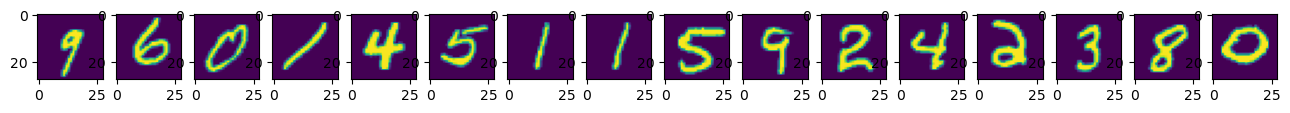

In [13]:
from utils.mnist import mnist_to_numpy, normalize
import random
import matplotlib.pyplot as plt

%matplotlib inline

data_dir = "/tmp/data"
X, Y = mnist_to_numpy(data_dir, train=False)

# randomly sample 16 images to inspect
mask = random.sample(range(X.shape[0]), 16)
samples = X[mask]
labels = Y[mask]
# plot the images
fig, axs = plt.subplots(nrows=1, ncols=16, figsize=(16, 1))

for i, splt in enumerate(axs):
    splt.imshow(samples[i])

In [14]:
print(samples.shape, samples.dtype)

(16, 28, 28) uint8


Before we invoke the SageMaker PyTorch model server with `samples`, we need to do
some pre-processing
- convert its data type to 32 bit floating point
- normalize each channel (only one channel for MNIST)
- add a channel dimension

In [15]:
samples = normalize(samples.astype(np.float32), axis=(1, 2))

res = predictor.predict({"inputs": np.expand_dims(samples, axis=1).tolist()})

The response is a list with probability vectors for each sample.

In [16]:
predictions = np.argmax(np.array(res, dtype=np.float32), axis=1).tolist()
print("Predicted digits: ", predictions)

Predicted digits:  [9, 6, 0, 1, 4, 5, 1, 1, 5, 9, 2, 4, 2, 3, 8, 0]


## Test and debug the entry point before deployment

When deploying a model to a SageMaker endpoint, it is a good practice to test the entry 
point. The following snippet shows you how you can test and debug the `model_fn` and 
`transform_fn` you implemented in the entry point for the inference image.  

In [17]:
!pygmentize code/test_inference.py

import json
import os
import shutil
import tarfile

import boto3
import botocore
import numpy as np
import sagemaker

from inference import input_fn, model_fn, output_fn, predict_fn


def fetch_model(model_data):
    """Untar the model.tar.gz object either from local file system
    or a S3 location

    Args:
        model_data (str): either a path to local file system starts with
        file:/// that points to the `model.tar.gz` file or an S3 link
        starts with s3:// that points to the `model.tar.gz` file

    Returns:
        model_dir (str): the directory that contains the uncompress model
        checkpoint files
    """

    model_dir = "/tmp/model"
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    if model_data.startswith("file"):
        _check_model(model_data)
        shutil.copy2(
            os.path.join(model_dir, "model.tar.gz"), os.path.join(model_dir, "model.tar.gz")
        )
    elif model_data.startswith("s3"):
        # get bucket name

The `test` function simulates how the inference container works. It pulls the model
artifact and loads the model into 
memory by calling `model_fn` and parse `model_dir` to it. 
When it receives a request,
it calls `input_fn`, `predict_fn` and `output_fn` consecutively. 

Implementing such a test function helps you to debug the entry point before putting it into the production. 
If `test` runs correctly, then you can be certain that if the incoming data and its content type are what they are supposed to be, then the endpoint is going to work as expected. 

## (Optional) Clean up 

If you do not plan to use the endpoint, you should delete it to free up some computation 
resource. If you use local, you will need to manually delete the docker container bounded
at port 8080 (the port that listens to the incoming request).


In [18]:
import os

if not local_mode:
    predictor.delete_endpoint()
else:
    os.system("docker container ls | grep 8080 | awk '{print $1}' | xargs docker container rm -f")